In [1]:
from keras.models import Model
from keras.layers import Input
from keras.optimizers import *
from keras.datasets import mnist
from functools import partial

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

# Local imports
from unet import unet_cell, LEAKY_RELU_ALPHA, BATCH_NORM_MOMENTUM
from builders import build_upscaler, build_upscaler_v2, build_discriminator
from utils import reduce_resolution

batch_size = 100
GRADIENT_PENALTY_WEIGHT = 10
import WGAN_utils
from WGAN_utils import wasserstein_loss, gradient_penalty_loss, RandomWeightedAverage
WGAN_utils.batch_size=batch_size

Using TensorFlow backend.


In [2]:
# Load MNIST training data
(X_train, _), (_, _) = mnist.load_data() # No need for labels or test set
X_train = X_train.reshape(-1, 28, 28, 1)
X_train = X_train / 255.0 # Normalize

In [12]:
# Define inputs
low_res_input = Input(shape=(None, None, 1))
# TODO: dimensions of low_res_input should probably be divisible 
# by 2**{num_layers}
high_res_input = Input(shape=(None, None, 1)) # This should really have dimensions twice that of low_res_input

# Build upscaler / discriminator
upscaler = build_upscaler_v2(
    low_res_input,
    output_size=(28, 28),
    resize_method='nearest_neighbor',
    align_corners=True,
    num_filters_in_layer=[16, 32, 64, 32],
    num_cells_in_layer=[3, 3, 3, 3],
    bottleneck_before_concat=True)
preliminary_discriminator = build_discriminator(low_res_input, high_res_input, 
                                                use_batch_norm=False, 
                                                activation_in_final_layer=False) # Use default parameters


# Define optimizers and compile models
upscaler_optimizer = Adam(0.0001, beta_1=0.5, beta_2=0.9)
upscaler.compile(loss='binary_crossentropy', 
                 optimizer=upscaler_optimizer)

discriminator_optimizer = Adam(0.0001, beta_1=0.5, beta_2=0.9)
preliminary_discriminator.compile(loss='binary_crossentropy', 
                      optimizer=discriminator_optimizer, 
                      metrics=['accuracy'])

for layer in preliminary_discriminator.layers:
    layer.trainable = True
for layer in upscaler.layers:
    layer.trainable = False
preliminary_discriminator.trainable = True
upscaler.trainable = False

generator_input = Input(shape=(None, None, 1))
generated_samples = upscaler(generator_input)
discriminator_output_from_generator = preliminary_discriminator([generator_input, generated_samples])

low_res_input_for_discriminator = Input(shape=(None, None, 1))
real_samples = Input(shape=(None, None, 1))
discriminator_output_from_real_samples = preliminary_discriminator([low_res_input_for_discriminator, real_samples])

# We also need to generate weighted-averages of real and generated samples, to use for the gradient norm penalty.
averaged_samples = RandomWeightedAverage()([real_samples, generated_samples])
# We then run these samples through the discriminator as well. Note that we never really use the discriminator
# output for these samples - we're only running them to get the gradient norm for the gradient penalty loss.
averaged_samples_out = preliminary_discriminator([generator_input, averaged_samples])

# The gradient penalty loss function requires the input averaged samples to get gradients. However,
# Keras loss functions can only have two arguments, y_true and y_pred. We get around this by making a partial()
# of the function with the averaged samples here.
partial_gp_loss = partial(gradient_penalty_loss,
                          averaged_samples=averaged_samples,
                          gradient_penalty_weight=GRADIENT_PENALTY_WEIGHT)
partial_gp_loss.__name__ = 'gradient_penalty'  # Functions need names or Keras will throw an error

discriminator = Model(inputs=[generator_input, low_res_input_for_discriminator, real_samples],
                            outputs=[discriminator_output_from_generator,
                                     discriminator_output_from_real_samples,
                                     averaged_samples_out])

discriminator.compile(optimizer=discriminator_optimizer,
                            loss=[wasserstein_loss,
                                  wasserstein_loss,
                                  partial_gp_loss])

for layer in preliminary_discriminator.layers:
    layer.trainable = False
for layer in upscaler.layers:
    layer.trainable = True
preliminary_discriminator.trainable = False
upscaler.trainable = True

low_res_input_for_combined_model = Input(shape=(None, None, 1))
upscaled_imgs = upscaler(low_res_input_for_combined_model)
valid = preliminary_discriminator([low_res_input_for_combined_model, upscaled_imgs])

# The combined model  (stacked upscaler and discriminator) takes
# low-res image as input and returns an upsampled image from the 
# upscaler and a validity score given by the discriminator
combined = Model(low_res_input_for_combined_model, [valid, upscaled_imgs])
combined.compile(loss=[wasserstein_loss, 'mean_absolute_error'], 
                 optimizer=upscaler_optimizer, 
                 metrics = ['accuracy'])
# Notice: the combined model was compiled *after* freezing the discriminator's weights

print('combined summary')
combined.summary()
print('discriminator summary')
discriminator.summary()
print('preliminary_discriminator summary')
preliminary_discriminator.summary()
print('upscaler summary')
upscaler.summary()

combined summary
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           (None, None, None, 1 0                                            
__________________________________________________________________________________________________
model_9 (Model)                 (None, 28, 28, 1)    135047      input_18[0][0]                   
__________________________________________________________________________________________________
model_10 (Model)                (None, 1)            120497      input_18[0][0]                   
                                                                 model_9[2][0]                    
Total params: 255,544
Trainable params: 134,123
Non-trainable params: 121,421
__________________________________________________________________________________________________
discriminator 

C:\Users\Daniel\Anaconda3\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [13]:
# Define training parameters
train_steps = 1000
print_every_n_steps = 20
print_results = True
plot_results = True
repeat_discriminator_training_n_times = 1
# batch_size defined in first cell

# Create a dictionary for storing training metrics over time
training_metrics = {
    'step': [],
    'd_loss': [],
    'd_acc': [],
    'g_loss': []
}

# We make three label vectors for training. positive_y is the label vector for real samples, with value 1.
# negative_y is the label vector for generated samples, with value -1. The dummy_y vector is passed to the
# gradient_penalty loss function and is not used.
positive_y = np.ones((batch_size, 1), dtype=np.float32)
negative_y = -positive_y
dummy_y = np.zeros((batch_size, 1), dtype=np.float32)

C:\Users\Daniel\Anaconda3\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Step 20:
    [D loss: 8.145836, accuracy: -0.9195]
    [G loss: 1.410664]


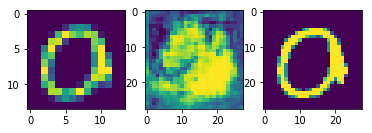

Step 40:
    [D loss: -0.239957, accuracy: -6.8894]
    [G loss: 7.838196]


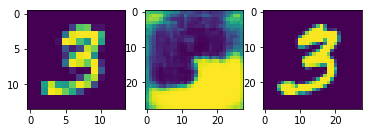

Step 60:
    [D loss: -0.930638, accuracy: -5.4000]
    [G loss: 5.680038]


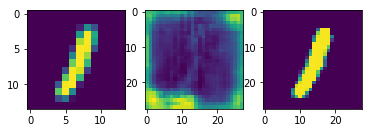

Step 80:
    [D loss: -2.582935, accuracy: -2.5805]
    [G loss: 3.003482]


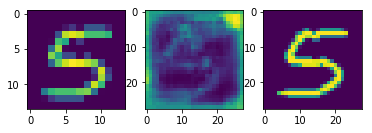

Step 100:
    [D loss: -2.917655, accuracy: -1.6531]
    [G loss: 2.308970]


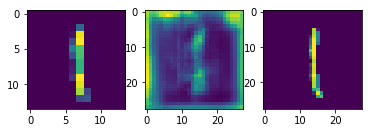

Step 120:
    [D loss: -3.216846, accuracy: -0.8814]
    [G loss: 1.898070]


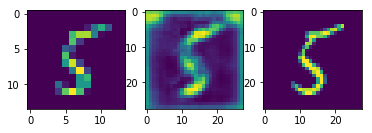

Step 140:
    [D loss: -3.508629, accuracy: -0.5855]
    [G loss: 1.510940]


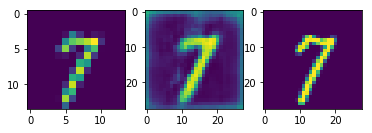

Step 160:
    [D loss: -3.756047, accuracy: -1.7314]
    [G loss: 1.886175]


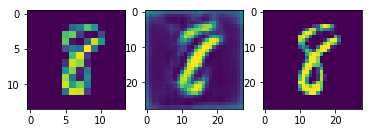

Step 180:
    [D loss: -3.366197, accuracy: -0.8507]
    [G loss: 2.014615]


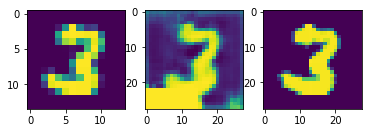

Step 200:
    [D loss: -3.259489, accuracy: -1.0439]
    [G loss: 0.593327]


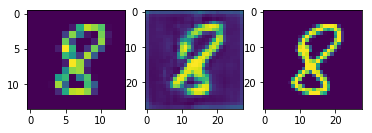

Step 220:
    [D loss: -3.241552, accuracy: -1.0865]
    [G loss: 1.257512]


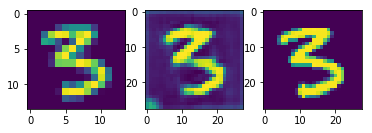

Step 240:
    [D loss: -2.898615, accuracy: -0.2224]
    [G loss: 0.966310]


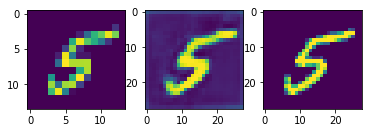

Step 260:
    [D loss: -2.534064, accuracy: -0.4549]
    [G loss: 1.700349]


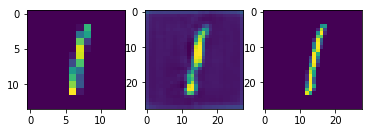

Step 280:
    [D loss: -2.572691, accuracy: -1.0151]
    [G loss: 0.865610]


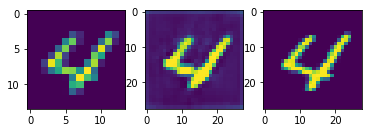

Step 300:
    [D loss: -2.345087, accuracy: -1.5923]
    [G loss: 2.059990]


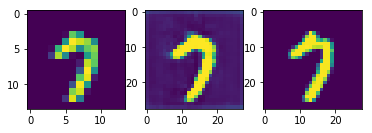

Step 320:
    [D loss: -2.249019, accuracy: -1.6822]
    [G loss: 2.105547]


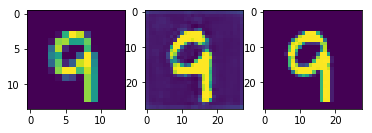

Step 340:
    [D loss: -1.888377, accuracy: -1.2528]
    [G loss: 1.244093]


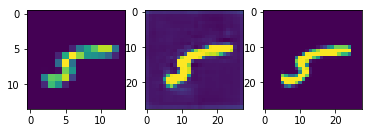

Step 360:
    [D loss: -2.217180, accuracy: -1.9232]
    [G loss: 1.699934]


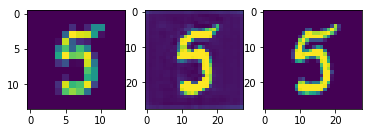

Step 380:
    [D loss: -1.863136, accuracy: -1.9389]
    [G loss: 1.418492]


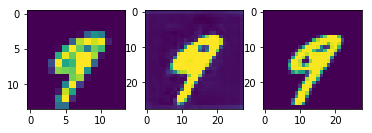

Step 400:
    [D loss: -1.934352, accuracy: -1.7499]
    [G loss: 1.617065]


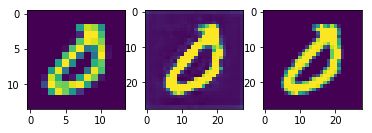

Step 420:
    [D loss: -1.717820, accuracy: -2.0248]
    [G loss: 1.419960]


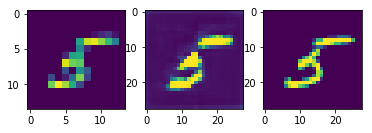

Step 440:
    [D loss: -1.882577, accuracy: -2.0488]
    [G loss: 1.097686]


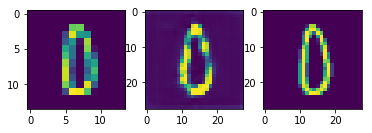

Step 460:
    [D loss: -1.499344, accuracy: -2.2667]
    [G loss: 2.719296]


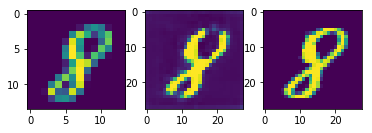

Step 480:
    [D loss: -1.485841, accuracy: -1.7744]
    [G loss: 2.197760]


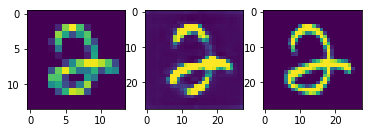

Step 500:
    [D loss: -1.507796, accuracy: -1.6476]
    [G loss: 2.020605]


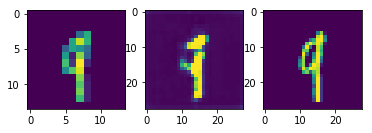

Step 520:
    [D loss: -1.496901, accuracy: -1.1778]
    [G loss: 0.489381]


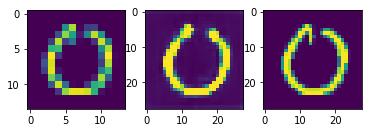

Step 540:
    [D loss: -1.329625, accuracy: -1.2570]
    [G loss: 1.108000]


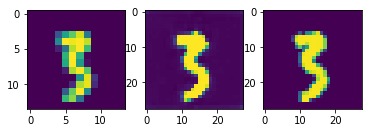

Step 560:
    [D loss: -1.148048, accuracy: -0.8574]
    [G loss: 2.399235]


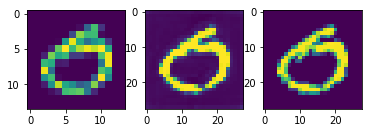

Step 580:
    [D loss: -1.079316, accuracy: -1.3308]
    [G loss: 1.943346]


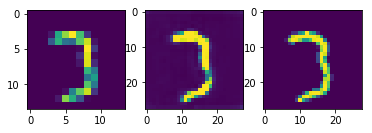

Step 600:
    [D loss: -1.114356, accuracy: -2.4075]
    [G loss: 1.693969]


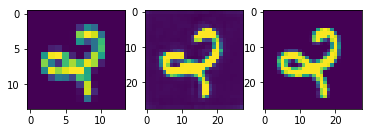

Step 620:
    [D loss: -1.210666, accuracy: -1.9817]
    [G loss: 1.247542]


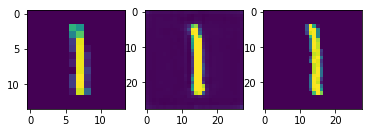

Step 640:
    [D loss: -1.102002, accuracy: -2.4390]
    [G loss: 1.497282]


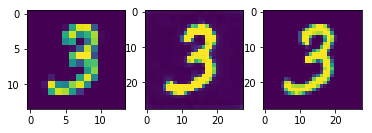

Step 660:
    [D loss: -1.077909, accuracy: -2.3002]
    [G loss: 2.220885]


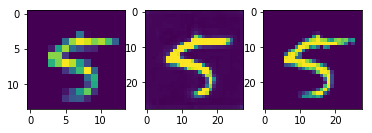

Step 680:
    [D loss: -0.880161, accuracy: -3.3989]
    [G loss: 3.367286]


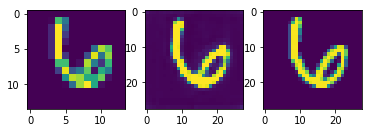

Step 700:
    [D loss: -0.872408, accuracy: -3.9763]
    [G loss: 3.269660]


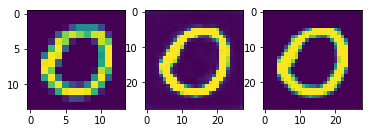

Step 720:
    [D loss: -0.836973, accuracy: -3.0189]
    [G loss: 3.831536]


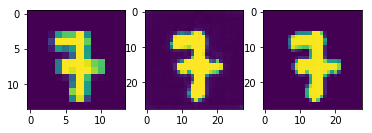

Step 740:
    [D loss: -0.890451, accuracy: -4.1884]
    [G loss: 4.807147]


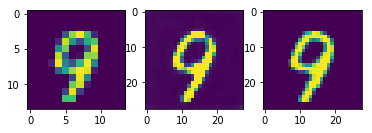

Step 760:
    [D loss: -0.732924, accuracy: -2.9661]
    [G loss: 3.336961]


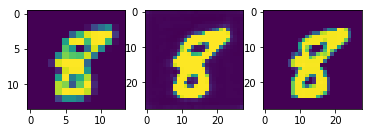

Step 780:
    [D loss: -0.817358, accuracy: -2.6112]
    [G loss: 2.133194]


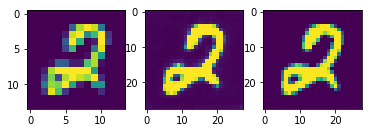

Step 800:
    [D loss: -0.707008, accuracy: -3.3236]
    [G loss: 3.972398]


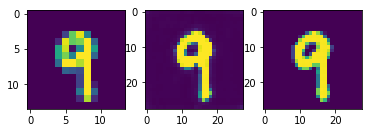

Step 820:
    [D loss: -0.650442, accuracy: -2.0696]
    [G loss: 2.460703]


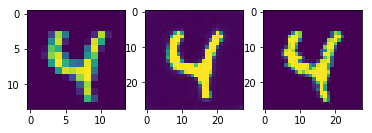

Step 840:
    [D loss: -0.629345, accuracy: -4.2908]
    [G loss: 4.119249]


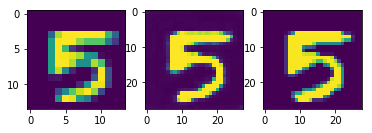

Step 860:
    [D loss: -0.605801, accuracy: -3.4051]
    [G loss: 4.372614]


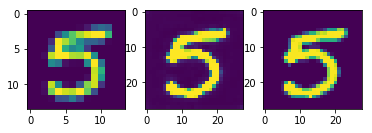

Step 880:
    [D loss: -0.580863, accuracy: -3.3090]
    [G loss: 3.231210]


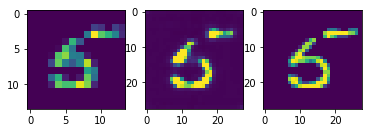

Step 900:
    [D loss: -0.717757, accuracy: -3.1032]
    [G loss: 2.461427]


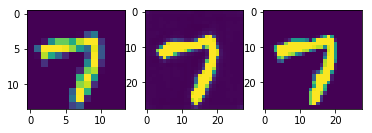

Step 920:
    [D loss: -0.510866, accuracy: -1.6630]
    [G loss: 2.953849]


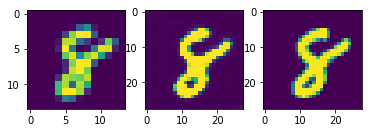

Step 940:
    [D loss: -0.457288, accuracy: -3.8348]
    [G loss: 3.608169]


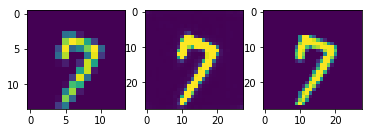

Step 960:
    [D loss: -0.514343, accuracy: -3.2253]
    [G loss: 3.755782]


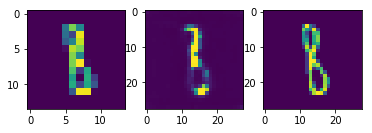

Step 980:
    [D loss: -0.472628, accuracy: -4.6255]
    [G loss: 5.248396]


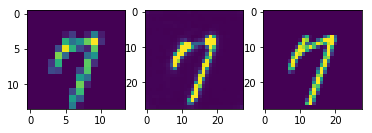

Step 1000:
    [D loss: -0.543347, accuracy: -5.4784]
    [G loss: 5.717793]


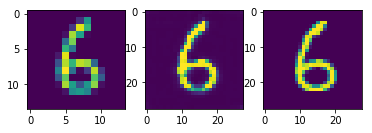

In [14]:
for step in range(1, train_steps + 1):
    
    # ---------------------
    #  Train Discriminator
    # ---------------------
    
    # Select a random half batch of images
    num_images = len(X_train)
    for train_discriminator in range(repeat_discriminator_training_n_times):
        random_idxs = np.random.randint(num_images, size=batch_size)
        imgs_to_pass_through_upscaler = X_train[random_idxs]
        low_res_imgs_to_pass_through_upscaler = reduce_resolution(imgs_to_pass_through_upscaler)

        random_idxs = np.random.randint(num_images, size=batch_size)
        real_imgs = X_train[random_idxs]
        low_res_imgs_to_pass_through_discriminator = reduce_resolution(real_imgs)

        # Train the discriminator
        d_loss = discriminator.train_on_batch( 
            x=[low_res_imgs_to_pass_through_upscaler, low_res_imgs_to_pass_through_discriminator, real_imgs], # Training data
            y=[negative_y, positive_y, dummy_y]) # Labels
    
    # ---------------------
    #  Train upscaler
    # ---------------------

    random_idxs = np.random.randint(num_images, size=batch_size)
    original_imgs = X_train[random_idxs]
    new_low_res_imgs = reduce_resolution(original_imgs)
    
    # Train the upscaler
    g_loss = combined.train_on_batch(
        x=new_low_res_imgs, 
        y=[positive_y, original_imgs])
        
    if step % print_every_n_steps == 0:
        # Store metrics over time
        training_metrics['step'].append(step)
        training_metrics['d_loss'].append(d_loss[0])
        training_metrics['d_acc'].append(d_loss[1])
        training_metrics['g_loss'].append(g_loss[0])
        
        # Print current metrics
        if print_results:
            print("Step {}:".format(step))
            print("    [D loss: {:0.6f}, accuracy: {:0.4f}]".format(
                training_metrics['d_loss'][-1],
                training_metrics['d_acc'][-1]))
            print("    [G loss: {:0.6f}]".format(
                training_metrics['g_loss'][-1]))
        
        # Plot example low_res vs upsampling vs original
        if plot_results:
            gen_imgs = upscaler.predict(low_res_imgs_to_pass_through_discriminator)
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
            ax1.imshow(low_res_imgs_to_pass_through_discriminator[0, :, :, 0])
            ax2.imshow(gen_imgs[0, :, :, 0])
            ax3.imshow(real_imgs[0, :, :, 0])
            plt.show()

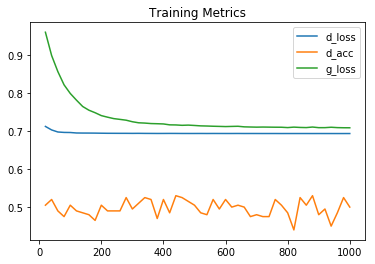

In [6]:
steps = training_metrics['step']
for key, values in training_metrics.items():
    if key == 'step': continue
    plt.plot(steps, values, label=key)
plt.title('Training Metrics')
plt.legend();

In [7]:
def save_models():
    upscaler.save('./models/upscaler_mnist.h5')
    discriminator.save('./models/discriminator_mnist.h5')
    combined.save('./models/combined_mnist.h5')

In [8]:
def show_examples():
    from keras.models import load_model

    # Load the upscaler
    upscaler = load_model('./models/upscaler_mnist.h5')

    # Upsample five images
    fi = 314 # First index
    images = X_train[fi:fi + 5]
    upsampled = upscaler.predict(images)
    upupsampled = upscaler.predict(upsampled)

    # Create a figure showing the results
    for i, (original, up, upup) in enumerate(zip(images, upsampled, upupsampled)):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        if i == 0:
            fig.suptitle("Original vs Upsampled vs Twice Upsampled")
        ax1.imshow(original[:, :, 0])
        ax2.imshow(up[:, :, 0])
        ax3.imshow(upup[:, :, 0])
        plt.show()

In [9]:
# save_models()
# show_examples()

# Transfering weights to model that produces larger outputs

In [10]:
# Define inputs
low_res_input = Input(shape=(None, None, 1))

# Build upscaler with different output size
new_upscaler = build_upscaler_v2(
    low_res_input,
    output_size=(128, 128),  # Previous output size was (28, 28)
    resize_method='bicubic', # Notice: We've even changed resize method from NN to bicubic
    align_corners=True,
    num_filters_in_layer=[16, 32, 64, 32],
    num_cells_in_layer=[3, 3, 3, 3],
    bottleneck_before_concat=True)

# Compile the new upscaler
new_upscaler_optimizer = Adam(0.001, 0.5)
new_upscaler.compile(loss='binary_crossentropy', 
                     optimizer=new_upscaler_optimizer)

# Transfer weights from original upscaler to new upscaler
for new_layer, pretrained_layer in zip(new_upscaler.layers, upscaler.layers):
    learned_weights = pretrained_layer.get_weights()
    new_layer.set_weights(learned_weights)

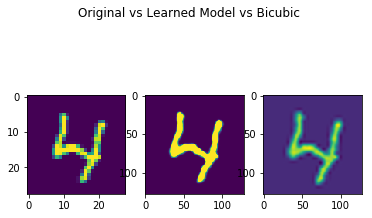

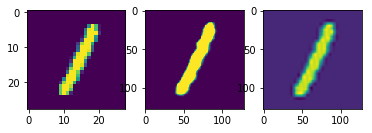

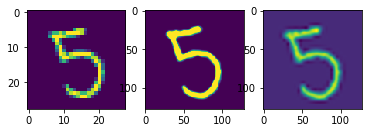

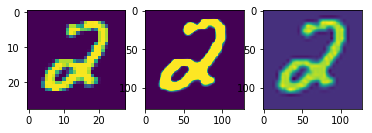

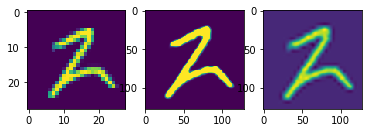

In [11]:
fi = 314 # First index
images = X_train[fi:fi+5] # Select five images
upsampled = new_upscaler.predict(images)

# Compare our model to vanilla bicubic resize:
with tf.Session() as sess:
    bicubic = sess.run(tf.image.resize_bicubic(images, (128, 128), align_corners=True))

# Create a figure showing the results
for i, (original, up, control) in enumerate(zip(images, upsampled, bicubic)):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    if i == 0:
        fig.suptitle("Original vs Learned Model vs Bicubic")
    ax1.imshow(original[:, :, 0])
    ax2.imshow(up[:, :, 0])
    ax3.imshow(control[:, :, 0])
    plt.show()